In [1]:
pip install Pyarrow statsmodels scikit-learn 

  Using cached https://files.pythonhosted.org/packages/00/bd/4c03789f723337723670e8cf8935b18e170e7af3813ec38e71d2cfb0bd93/pyarrow-12.0.1-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
ERROR: Could not install packages due to an EnvironmentError: [Errno 30] Read-only file system: '/opt/conda/envs/dsua-111/lib/python3.7/site-packages/pyarrow'

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import statsmodels.formula.api as smf
df = pd.read_csv("states_data.csv")
vep12_turnout = df["vep12_turnout"]
prcapinc = df["prcapinc"]

In [3]:
def my_standardize(n):
    standardizedArray = np.zeros_like(n, dtype=float)
    mean = np.mean(n)
    standardDeviation = np.std(n)
    for i in range(len(n)):
        z = (n[i] - mean)/standardDeviation
        standardizedArray[i] = z
    return standardizedArray
    

Text(0.5, 1.0, 'standardized prcapinc vs vep12_turnout')

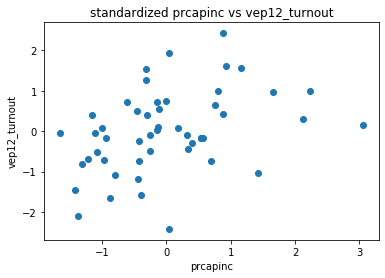

In [4]:
vep12_turnout_standard = my_standardize(vep12_turnout)
prcapinc_standard = my_standardize(prcapinc)
plt.scatter(prcapinc_standard,vep12_turnout_standard)
plt.xlabel("prcapinc") 
plt.ylabel("vep12_turnout")
plt.title("standardized prcapinc vs vep12_turnout")

The data points on both scatterplots look the same relatively to other points, they are just on different scales. The standardized scatterplot makes it easier to compare beccause the mean is 0 and standard dviation is 1

In [6]:
def my_corr(x,y):
    standardize_x = my_standardize(x)
    standardize_y = my_standardize(y)
    correlation = np.mean(standardize_x* standardize_y)
    return correlation

def gen_data():
    m0, m1, v0, v1 = np.random.uniform(-5, 5, 4)
    x = np.random.normal(m0, v0**2, 100)
    y = np.random.normal(m1, v1**2, 100)
    return x, y
    
def test_corr(my_corr):
    for _ in range(100):
        x, y = gen_data()
        if not np.isclose(np.corrcoef(x,y)[0, 1], my_corr(x, y)):
            return False
    return True

test_corr(my_corr)

True

In [7]:
print(my_corr(prcapinc,vep12_turnout))

0.39054295261645455


There is a positive relationship with pearson correlation coefficient of 0.39 between mean income per capita and the voter turnout rate in the 2012 presidential election. States that have higher mean income per capita are more likely to have a higher voter turnout. Yet, we can't conclude that people with higher incomes are more likely to vote because correlation does not imply causation. Other factors can influence the voter turnout.

In [8]:
def my_slope(x, y):
    standardize_x = np.sum((x - np.mean(x)) * (y - np.mean(y)))
    standardize_y = np.sum((x - np.mean(x)) ** 2)
    slope = standardize_x / standardize_y
    return slope

my_slope(prcapinc,vep12_turnout)

0.0005735134590888056

In [9]:
def my_intercept(x, y):
    intercept = np.mean(y) - my_slope(x, y)*np.mean(x)
    return intercept

my_intercept(prcapinc,vep12_turnout)

def test_reg(my_intercept, my_slope):
    for _ in range(100):
        u, v = gen_data()
        X = np.transpose(np.vstack([np.repeat(1.0, len(u)), u]))
        a, b = np.dot(np.matmul(np.linalg.inv(np.matmul(X.T, X)), X.T), v)
        if not np.isclose(b, my_slope(u, v)):
            return False
        if not np.isclose(a, my_intercept(u, v)):
            return False
    return True

test_reg(my_intercept, my_slope)

True

In [10]:
print("This is the slope", my_slope(prcapinc,vep12_turnout))
print("This is the intercept", my_intercept(prcapinc,vep12_turnout))

This is the slope 0.0005735134590888056
This is the intercept 41.61161411730767


Slope: Indicates the average increase in voter turnout (vep12_turnout) is 0.0005735134590888056 for each dollar increase in mean income per capita (prcapinc). Intercept: Represents the expected value of vep12_turnout equals 41.61161411730767 when prcapinc is 0. While the intercept can provide insights into the data, it might not always have a meaningful interpretation, especially if a prcapinc of 0 is not plausible.

In [11]:
def predict_reg(b, a, x):
    y = b*x + a
    return y

In [12]:
print("This is the voter turnout rate for mean per capita of $15000", predict_reg(my_slope(prcapinc,vep12_turnout), my_intercept(prcapinc,vep12_turnout), 15000))
print("This is the voter turnout rate for mean per capita of $25000", predict_reg(my_slope(prcapinc,vep12_turnout), my_intercept(prcapinc,vep12_turnout), 25000))
print("This is the voter turnout rate for mean per capita of $30000", predict_reg(my_slope(prcapinc,vep12_turnout), my_intercept(prcapinc,vep12_turnout), 30000))


This is the voter turnout rate for mean per capita of $15000 50.21431600363975
This is the voter turnout rate for mean per capita of $25000 55.949450594527804
This is the voter turnout rate for mean per capita of $30000 58.81701788997184


Text(0.5, 1.0, 'unstandardized prcapinc vs vep12_turnout')

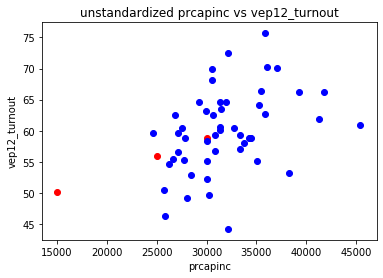

In [13]:
point1 = predict_reg(my_slope(prcapinc,vep12_turnout), my_intercept(prcapinc,vep12_turnout), 15000)
point2 = predict_reg(my_slope(prcapinc,vep12_turnout), my_intercept(prcapinc,vep12_turnout), 25000)
point3 = predict_reg(my_slope(prcapinc,vep12_turnout), my_intercept(prcapinc,vep12_turnout), 30000)

plt.scatter([15000, 25000, 30000], [point1, point2, point3], color='red')
plt.scatter(prcapinc,vep12_turnout, color='blue')
plt.xlabel("prcapinc") 
plt.ylabel("vep12_turnout")
plt.title("unstandardized prcapinc vs vep12_turnout")

They are close to the observed data. The prediction is trust worthy, although we need to consider that 1 point in the added data is outside the range of the observed prcapinc, thus that point might not be a reliable extrapolated point

In [14]:
import statsmodels.formula.api as smf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
df = pd.read_csv("states_data.csv")

results = smf.ols('vep12_turnout ~ prcapinc', data=df).fit()
print(results.summary())

print("the value of the slope coefficient is 0.0006")
print("the value of T-statistics is 2.939")
print("the value of p-value is 0.005")

                            OLS Regression Results                            
Dep. Variable:          vep12_turnout   R-squared:                       0.153
Model:                            OLS   Adj. R-squared:                  0.135
Method:                 Least Squares   F-statistic:                     8.639
Date:                Sat, 24 Aug 2024   Prob (F-statistic):            0.00505
Time:                        05:03:23   Log-Likelihood:                -160.15
No. Observations:                  50   AIC:                             324.3
Df Residuals:                      48   BIC:                             328.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     41.6116      6.293      6.612      0.0

In [15]:
results = smf.ols('vep12_turnout ~ prcapinc + pop2010 + college + unemploy + urban', data=df).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:          vep12_turnout   R-squared:                       0.294
Model:                            OLS   Adj. R-squared:                  0.213
Method:                 Least Squares   F-statistic:                     3.658
Date:                Sat, 24 Aug 2024   Prob (F-statistic):            0.00745
Time:                        05:03:48   Log-Likelihood:                -155.59
No. Observations:                  50   AIC:                             323.2
Df Residuals:                      44   BIC:                             334.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     38.7996      8.742      4.438      0.0

In [16]:
Y = df[["vep12_turnout"]]
X = df[["prcapinc", "pop2010", "college", "unemploy", "urban"]]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=2023)
X_test


,prcapinc,pop2010,college,unemploy,urban
34,31322,11536504,22.9,6.3,77.4
35,28089,3751351,21.9,4.9,65.3
9,30051,9687653,25.7,4.7,71.6
2,25725,2915918,19.1,5.9,52.5
21,31954,9883640,24.3,7.0,74.7
12,27098,1567582,24.0,5.3,66.4
38,33733,1052567,29.1,5.4,90.9
10,32160,1360301,28.2,3.4,91.5
42,30222,25145561,24.5,6.0,82.5
19,39247,5773552,34.5,4.2,86.1


In [17]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)